# Data Wrangling


## Much of the unique code that you will write for RNAseq analyses and many other data science projects is to extract and reformat data. Let's review our question and pipeline to determine what data we need to extract.

## Let's review the question that we will answer:
### What are the differentially expressed genes between HER2 positive and Triple-Negative Breast Cancer (TNBC)?
Breast cancer is a classic example of the use of precision treatment. Patients with cancerous cells that express the estrogen receptor (ER+) receive hormone therapy and a recent [report](https://www.ncbi.nlm.nih.gov/pubmed/29860917?dopt=Abstract) demonstrates that a subset of those patients based entirely on gene expression do not benefit from chemotherapy. Likewise, patients with cancerous cells with amplified ERBB2 (HER2) are treated with a targeted therapy that has dramatically improved the prognosis of those patients. However, patients with breast cancer cells that do not express ER, HER2, or the progesteron receptor (PR) have what is known as triple-negative breast cancer (TNBC). There are currently no targeted therapies for TNBC breast cancer. One might be interested in what genes are expressed differently in HER2+ vs. TNBC given that HER2+ are typically also ER and PR negative. We will ask that question using the TCGA counts data. 



## Our pipeline
In the pipeline image, the red text indicates the names of the R packages we will use to perform the analysis, the yellow boxes indicate the data (raw or processed), and the grey indicates what we will do in each step. Note that we will use [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) to identify differentially expressed genes (DEGs). This is a highly cited package that uses a negative binomial distribution to calculate DEGs. However, there are multiple pipelines and programs to do this. [Knoweng](http://education.knoweng.org/sequenceng/) has a nice interface to explore other options, including the strengths and weaknesses of each.
![](https://github.com/davidnboone/test-image/blob/master/overview-image.jpg?raw=true "pipeline overview")

## To perform this analysis we need to:
1. Extract and calculate HER2 and TNBC status of each sample.
2. Extract count and abundance data from those samples.
3. The count and abundance data is transformed and currently at the transcript level, so we will need to untransform and collapse to gene level to perform the differential expressional analysis. In this notebook we will prep the data into the proper form to collapse into gene level.

___
___
___

## We still need the proper R packages loaded. We will need to start by reloading them with the same code as the previous Notebook.
Of course you can use the typical library() command to load each as well.


In [6]:
#you can very easily use "install.packages" or "biocLite" to install the packages and "library" to load them
#however, instead I am installing a package called pacman that will determine if a package is already installed
#if it is not it will install it and after will load it
#this method is convenient when sharing code that requires the use of others packages

if (!require("pacman")) install.packages("pacman")
pacman::p_load(R.utils, data.table, tximport, DESeq2, biomaRt, jsonlite, BiocParallel, ggplot2, gplots, RColorBrewer, devtools, pheatmap)


## Set the working directory to the workspace set up in the previous notebook.
 You can check to deterimine if you are in the correct directory by examining your working directory. If it is not the proper workspace then change to proper directory.


In [7]:
getwd()

NULL

In [15]:
#only need to run if you are not in the proper working directory.
base_dir <- "/Volumes/Oesterreich"
setwd(base_dir)

project_name <- "TCGA_Her2_TNBC_DEGs"
date <- "2019_02_06" #use the same date as notebook 1
setwd(project_name)

getwd()


[1] "/Volumes/Oesterreich/TCGA_Her2_TNBC_DEGs"

___
___
___

# 1. Start the analysis. Extract and calculate HER2 and TNBC status of each patient.
To do this you must understand the TCGA Barcode. Let's take a look at what each portion of the barcode means.

### TCGA Barcode
 ![TCGA barcode](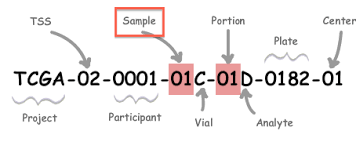 "barcode")
For our purposes we will focus on the first 12 alphanumeric digits of this code. "TCGA-XX-XXXX-XX". The first 6 Xs provide an anonymous identifier unique to each patient. The final 2 Xs (highlighed in a red box) define what type of sample it is, which is defined [here](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes). For the breast cancer data that we downloaded there are only three codes, "-01" is a solid tumor, "-06" is a metastatic tumor, and "-11" is normal solid tissue. For asking what are the difference between TNBC and HER2+ primary cancers, we will only be interested in the samples with "-01" as these are primary tumors. This is our first piece of information to extract data. However, we also need to know if the tumors are TNBC or HER2+. We can infer this based on the clinical data that we downloaded.

### Defining HER2+ and TNBC tumors
Read in the clinical data and examine it by running the code below.

In [9]:
############################################################################################
###################  Define HER2 positive and TNBC BC tumors ###############################
############################################################################################


# Read clinical data. Note from experience I know that there are both NAs and blank spaces. The na.strings = c("", "NA") command will force both to be NAs in the dataframe
brca.clin.data <- read.delim("./raw_data/tcga_brca.clinical", header = TRUE, stringsAsFactors = FALSE, na.strings = c("","NA"))
head(brca.clin.data)


sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,⋯,X_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_data.public.TCGA.BRCA.miRNA_GA_gene,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_data.public.TCGA.BRCA.miRNA_HiSeq_gene,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2,X_GENOMIC_ID_TCGA_BRCA_PDMarray
TCGA-3C-AAAU-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,6ef883fc-81f3-4089-95e0-86904ffc0d38,NA,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NA,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NA
TCGA-3C-AALI-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NA,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NA,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NA
TCGA-3C-AALJ-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,c924c2a8-ab41-4499-bb30-79705cc17d45,NA,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NA,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NA
TCGA-3C-AALK-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1a19e068-d213-41ef-aebb-104017a883cc,NA,TCGA-3C-AALK-01A-11D-A41E-01,TCGA-3C-AALK-01,NA,1a19e068-d213-41ef-aebb-104017a883cc,TCGA-3C-AALK-01A-11D-A41E-01,NA
TCGA-4H-AAAK-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,2ea9e472-a408-4ae0-975d-50a566f22b2a,NA,TCGA-4H-AAAK-01A-12D-A41E-01,TCGA-4H-AAAK-01,NA,2ea9e472-a408-4ae0-975d-50a566f22b2a,TCGA-4H-AAAK-01A-12D-A41E-01,NA
TCGA-5L-AAT0-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,32e61645-eb89-49f7-9876-85b1497c7e42,NA,TCGA-5L-AAT0-01A-12D-A41E-01,TCGA-5L-AAT0-01,NA,32e61645-eb89-49f7-9876-85b1497c7e42,TCGA-5L-AAT0-01A-12D-A41E-01,NA


The table is set up so that patients (notice the TCGA barcode) are listed as rows and clinical features as columns. To see a list of all clinical features by examing the column names. 

In [6]:
colnames(brca.clin.data)

[1] "sampleID"                                                        
  [2] "AJCC_Stage_nature2012"                                           
  [3] "Age_at_Initial_Pathologic_Diagnosis_nature2012"                  
  [4] "CN_Clusters_nature2012"                                          
  [5] "Converted_Stage_nature2012"                                      
  [6] "Days_to_Date_of_Last_Contact_nature2012"                         
  [7] "Days_to_date_of_Death_nature2012"                                
  [8] "ER_Status_nature2012"                                            
  [9] "Gender_nature2012"                                               
 [10] "HER2_Final_Status_nature2012"                                    
 [11] "Integrated_Clusters_no_exp__nature2012"                          
 [12] "Integrated_Clusters_unsup_exp__nature2012"                       
 [13] "Integrated_Clusters_with_PAM50__nature2012"                      
 [14] "Metastasis_Coded_nature2012"                                     
 [15] "Metastasis_nature2012"                                           
 [16] "Node_Coded_nature2012"                                           
 [17] "Node_nature2012"                                                 
 [18] "OS_Time_nature2012"                                              
 [19] "OS_event_nature2012"                                             
 [20] "PAM50Call_RNAseq"                                                
 [21] "PAM50_mRNA_nature2012"                                           
 [22] "PR_Status_nature2012"                                            
 [23] "RPPA_Clusters_nature2012"                                        
 [24] "SigClust_Intrinsic_mRNA_nature2012"                              
 [25] "SigClust_Unsupervised_mRNA_nature2012"                           
 [26] "Survival_Data_Form_nature2012"                                   
 [27] "Tumor_T1_Coded_nature2012"                                       
 [28] "Tumor_nature2012"                                                
 [29] "Vital_Status_nature2012"                                         
 [30] "X_EVENT"                                                         
 [31] "X_INTEGRATION"                                                   
 [32] "OS.time"                                                         
 [33] "OS"                                                              
 [34] "OS.unit"                                                         
 [35] "X_PANCAN_CNA_PANCAN_K8"                                          
 [36] "X_PANCAN_Cluster_Cluster_PANCAN"                                 
 [37] "X_PANCAN_DNAMethyl_BRCA"                                         
 [38] "X_PANCAN_DNAMethyl_PANCAN"                                       
 [39] "X_PANCAN_RPPA_PANCAN_K8"                                         
 [40] "X_PANCAN_UNC_RNAseq_PANCAN_K16"                                  
 [41] "X_PANCAN_miRNA_PANCAN"                                           
 [42] "X_PANCAN_mirna_BRCA"                                             
 [43] "X_PANCAN_mutation_PANCAN"                                        
 [44] "X_PATIENT"                                                       
 [45] "RFS.time"                                                        
 [46] "RFS"                                                             
 [47] "RFS.unit"                                                        
 [48] "X_TIME_TO_EVENT"                                                 
 [49] "X_TIME_TO_EVENT_UNIT"                                            
 [50] "X_cohort"                                                        
 [51] "X_primary_disease"                                               
 [52] "X_primary_site"                                                  
 [53] "additional_pharmaceutical_therapy"                               
 [54] "additional_radiation_therapy"                                    
 [55] "additional_surgery_locoregional_procedure"           

### Where are HER2 and TNBC statuses?
To determine TNBC we need to know if each tumor is positive or negative for estrogen receptor (ER), progesterone receptor (PR), and HER2. ER is determined by immunohistochemistry (IHC) and is directly reported for all patients under "breast_carcinoma_estrogen_receptor_status." PR is determined by immunohistochemistry and is directly reported for all patients under "breast_carcinoma_progesterone_receptor_status." However, HER2 is not directly reported for each patient. Instead, HER2 is determined clinically by two different tests (IHC and in situ hybridization) that are reported (if available) under "lab_proc_her2_neu_immunohistochemistry_receptor_status" and "lab_procedure_her2_neu_in_situ_hybrid_outcome_type." Often IHC is performed first and if an indeterminable result is obtained then in situ hybridization is performed. However, if you examine the data closely you will notice that in some instances IHC and in situ hybridization will be discordant. We will throw out those samples for our analysis as we cannot properly determine HER2 status. Otherwise if one of the two tests has a "positive" or "negative" result and the other test is NA or indeterminable, we will use the single test result. 

The clinical data above has more data than we are interested in, which can make it a bit more difficult to work with. Run the code below to select only the columns that we need to determine HER2 and TNBC status. These are the columns that provide information on ER, PR, and HER2. 

In [10]:
#code to pull out ER and PR final statuses and HER2 tests used to calculuate HER2 final status to make the clinical data easier to work with
brca.clin.selected <- brca.clin.data[, c("sampleID", "breast_carcinoma_estrogen_receptor_status", "breast_carcinoma_progesterone_receptor_status", "lab_proc_her2_neu_immunohistochemistry_receptor_status", "lab_procedure_her2_neu_in_situ_hybrid_outcome_type")]
head(brca.clin.selected)


sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type
TCGA-3C-AAAU-01,Positive,Positive,Negative,NA
TCGA-3C-AALI-01,Positive,Positive,Positive,NA
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,NA
TCGA-3C-AALK-01,Positive,Positive,Positive,NA
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,NA
TCGA-5L-AAT0-01,Positive,Positive,Negative,NA


### pseudocode to determine HER2 status
In the psuedocode below I abbreviate the column names lab_proc_her2_neu_immunohistochemistry_receptor_status as HER2 IHC and lab_procedure_her2_neu_in_situ_hybrid_outcome_type as HER2 FISH. 

Note that we replace NAs to "unknown" to make execution easier.

We will define each sample as HER2 positive, negative, or unknown. Unknown means that either the FISH and IHC are discordant or there was not a positive or negative call for either.
 


- if HER2 IHC is "positive" AND HER2 FISH is NOT "negative" then the sample is HER2 positive, else
- if HER2 FISH is "positive" AND HER2 IHC is NOT "negative" then the sample is HER2 positive, else
- if HER2 IHC is "negative" AND HER2 FISH is NOT "positive" then the sample is HER2 negative, else
- if HER2 FISH is "negative" AND HER2 IHC is NOT "positive" then the sample is HER2 negative, else
- we don't know


In [11]:
#set NAs to "unknown" to allow for easier logic in following steps
brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status[is.na(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status)] <- "unknown"
brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type[is.na(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type)] <- "unknown"

#create a new column that defines HER2 status as "Positive", "Negative", or "unknown"
brca.clin.selected$HER2 <- ifelse(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status == "Positive" &
                                    brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type != "Negative", "Positive",
                                  ifelse(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type == "Positive" &
                                           brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status != "Negative", "Positive",
                                         ifelse(brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status == "Negative" &
                                                  brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type != "Positive", "Negative",
                                                ifelse(brca.clin.selected$lab_procedure_her2_neu_in_situ_hybrid_outcome_type == "Negative" &
                                                         brca.clin.selected$lab_proc_her2_neu_immunohistochemistry_receptor_status != "Positive", "Negative", "unknown"))))


### Check the logic
Let's check that it worked in two different ways: 
1. spot checking the logic by looking directly at the table.
2. calculating the percent of samples that are HER2+, which should be ~15-20%. This is the known percentage of women diagnosed with HER2+ breast cancer.

In [12]:
head(brca.clin.selected)

#calculate number of HER2 pos, neg, and unknowns
num.her2.neg <- nrow(brca.clin.selected[brca.clin.selected$HER2 == "Negative", ])
num.her2.pos <- nrow(brca.clin.selected[brca.clin.selected$HER2 == "Positive", ])
num.her2.unk <- nrow(brca.clin.selected[brca.clin.selected$HER2 == "unknown", ])

#calculate percentage of HER2+ tumors
percent.her2.pos <- 100* num.her2.pos / (num.her2.neg + num.her2.pos)

message("number of HER2 negative samples")
num.her2.neg

message("number of HER2 positive samples")
num.her2.pos

message("number with indeterminate HER2 status")
num.her2.unk

message("percent of HER2 positive samples")
percent.her2.pos


sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type,HER2
TCGA-3C-AAAU-01,Positive,Positive,Negative,unknown,Negative
TCGA-3C-AALI-01,Positive,Positive,Positive,unknown,Positive
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,unknown,unknown
TCGA-3C-AALK-01,Positive,Positive,Positive,unknown,Positive
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,unknown,unknown
TCGA-5L-AAT0-01,Positive,Positive,Negative,unknown,Negative


number of HER2 negative samples


[1] 857

number of HER2 positive samples


[1] 206

number with indeterminate HER2 status


[1] 184

percent of HER2 positive samples


[1] 19.37912

### We cannot use all of the samples.
From the code above, we can see that there are 857 definitively HER2 negative tumors, 206 HER2 positive tumors, and 184 that we do not know. For the purposes of this exercise, we will exclude any unknowns. This makes our dataset smaller, but cleaner. We may even lose more samples after determining if samples are triple negative.

### Now you write the logic to determine if each sample is TNBC or not.
Note, if a sample is TNBC then ER, PR, **AND**, HER2 must all be negative. If any of them are positive, then they are not TNBC. There also will be some that we cannot determine because the known ER, PR, and HER2 will be negative, but at least one of the three is unknown. Store the values in a column named "TNBC" in the brca.clin.selected data frame. Have "NOT_TNBC" indicicate that the sample is NOT_TNBC, "TNBC" indicate that the sample is TNBC, and "unknown" mean it is unclear with the given data.

**Hint** be sure to change ER and PR NAs to "unknown" to make the logic easier like in the code above. The results should indicate that 176 samples are TNBC and 973 are not.

In [13]:
brca.clin.selected$breast_carcinoma_estrogen_receptor_status[is.na(brca.clin.selected$breast_carcinoma_estrogen_receptor_status)] <- "unknown"
brca.clin.selected$breast_carcinoma_progesterone_receptor_status[is.na(brca.clin.selected$breast_carcinoma_progesterone_receptor_status)] <- "unknown"

brca.clin.selected$TNBC <- ifelse(brca.clin.selected$breast_carcinoma_estrogen_receptor_status == "Negative" & 
                                 brca.clin.selected$breast_carcinoma_progesterone_receptor_status == "Negative" &
                                 brca.clin.selected$HER2 == "Negative", "TNBC",
                                                    ifelse(brca.clin.selected$breast_carcinoma_estrogen_receptor_status == "Positive" | 
                                 brca.clin.selected$breast_carcinoma_progesterone_receptor_status == "Positive" |
                                 brca.clin.selected$HER2 == "Postive", "NOT_TNBC", "Unknown"))

#determine number of TNBC and NOT_TNBC
nrow(brca.clin.selected[brca.clin.selected$TNBC == "TNBC", ])
nrow(brca.clin.selected[brca.clin.selected$TNBC == "NOT_TNBC", ])

#we are interested in the number of TNBC and number of HER2+
#count number of HER2+ tumors
nrow(brca.clin.selected[brca.clin.selected$HER2 == "Positive", ])


[1] 176

[1] 932

[1] 206

### Save the clinical data table
Now that we extracted and computed all of the appropriate data from the larger data table, we should save the new table with the generated feature into the dated directory. That way we can do not need to run the above code again, but can simply read in the table if we need it later.

In [16]:
#write clinical table with HER2 and TNBC features in analysis directory (date) so we can just load later instead of running the above code
write.table(brca.clin.selected, file = file.path(date, "brca.clin.data.her2.tnbc.txt"))



In [ ]:
#if you need to read the table you just saved, use this code, just remove the comment.
#do not do this unless you need to read the table
#brca.clin.selected <- read.table(file = file.path(date,"brca.clin.data.her2.tnbc.txt"), header = TRUE, stringsAsFactors = FALSE)

___
___
___

# 2. Read TCGA count and abundance data and parse for only HER2+ and TNBC Breast Cancer data
The downloaded data contains counts from ~197,000 transcripts across ~10,500 samples resulting in a nearly 15GB file. Simply reading this file using base R would require more RAM than your personal computer likely has, so instead we will use the fread function with the select command in the data.table package to only read the breast cancer data (both counts and tpm) that we are interested in exploring. fread is also much faster than read.table.

In [17]:
###################################################################################################################
######################### read counts data and parse only BRCA data ###############
###################################################################################################################


#note fread with selected columns is required because total tcga count file is too large to read into RAM
#the columns selected are those of breast cancer samples with both clinical and counts data
#fread can also not handle duplicates so those must be removed see the dups<- line

#this line reads the first 10 rows of the entire tcga counts data. This is used to find BRCA sample names and duplicates for fread
head.tcga.counts <- fread("./raw_data/tcga_countdata", nrows = 10)

#lets look at the first 10 columns of these 10 rows
head.tcga.counts[1:10, 1:10]

sample,TCGA-S9-A7J2-01,TCGA-G3-A3CH-11,TCGA-EK-A2RE-01,TCGA-D5-5538-01,TCGA-F4-6854-01,TCGA-AB-2863-03,TCGA-ZN-A9VQ-01,TCGA-EE-A17X-06,TCGA-05-4420-01
ENST00000548312.5,2.7161,1.4950,2.4698,3.1672,3.4224,3.8576,4.6956,3.6891,3.8933
ENST00000527779.1,4.3581,3.3848,6.4814,6.6932,7.1564,0.0000,6.3652,0.0000,4.8664
ENST00000454820.5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0354,0.0000
ENST00000535093.1,2.2979,0.0000,0.0000,0.0000,2.0337,6.1358,2.9152,0.0000,2.8168
ENST00000346219.7,5.0042,0.0000,0.0000,2.5386,3.3306,0.0000,4.8473,0.0000,4.0435
ENST00000570899.1,1.9775,0.0000,1.7120,0.0000,1.8999,0.0000,2.9893,3.2467,3.4259
ENST00000557761.1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
ENST00000625998.2,9.2392,0.0000,6.7611,7.3320,8.9146,7.9993,8.8161,7.3539,8.0970
ENST00000583693.5,9.0737,5.1353,5.7191,5.7107,7.3357,7.3258,7.1512,5.4032,7.3627
ENST00000383738.6,11.9026,0.0000,2.4815,1.4743,3.8041,4.1874,2.9543,2.2720,3.9967


For the count data, note that each column is a patient sample and each row is a transcript with an [Ensembl ID](https://useast.ensembl.org/Homo_sapiens/Info/Index). Note Ensembl transcripts begin with ENST and Ensembl gene IDs begin with ENSG. We want all of the transcripts, but only need IDs corresponding to the 176 TNBC samples and 206 HER2+ samples. To extract these we need to use the gene IDs corresponding to the TNBC and HER2+ samples from the clinical datatable. Let's look at how the format of those IDs correspond to those in the counts table.

In [18]:
#lets look at these 10 rows
head.tcga.counts[1:10,1:10]

#and compare the BRCA TCGA IDs from the clinical data
head(brca.clin.selected)

sample,TCGA-S9-A7J2-01,TCGA-G3-A3CH-11,TCGA-EK-A2RE-01,TCGA-D5-5538-01,TCGA-F4-6854-01,TCGA-AB-2863-03,TCGA-ZN-A9VQ-01,TCGA-EE-A17X-06,TCGA-05-4420-01
ENST00000548312.5,2.7161,1.4950,2.4698,3.1672,3.4224,3.8576,4.6956,3.6891,3.8933
ENST00000527779.1,4.3581,3.3848,6.4814,6.6932,7.1564,0.0000,6.3652,0.0000,4.8664
ENST00000454820.5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0354,0.0000
ENST00000535093.1,2.2979,0.0000,0.0000,0.0000,2.0337,6.1358,2.9152,0.0000,2.8168
ENST00000346219.7,5.0042,0.0000,0.0000,2.5386,3.3306,0.0000,4.8473,0.0000,4.0435
ENST00000570899.1,1.9775,0.0000,1.7120,0.0000,1.8999,0.0000,2.9893,3.2467,3.4259
ENST00000557761.1,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
ENST00000625998.2,9.2392,0.0000,6.7611,7.3320,8.9146,7.9993,8.8161,7.3539,8.0970
ENST00000583693.5,9.0737,5.1353,5.7191,5.7107,7.3357,7.3258,7.1512,5.4032,7.3627
ENST00000383738.6,11.9026,0.0000,2.4815,1.4743,3.8041,4.1874,2.9543,2.2720,3.9967


sampleID,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,lab_proc_her2_neu_immunohistochemistry_receptor_status,lab_procedure_her2_neu_in_situ_hybrid_outcome_type,HER2,TNBC
TCGA-3C-AAAU-01,Positive,Positive,Negative,unknown,Negative,NOT_TNBC
TCGA-3C-AALI-01,Positive,Positive,Positive,unknown,Positive,NOT_TNBC
TCGA-3C-AALJ-01,Positive,Positive,Indeterminate,unknown,unknown,NOT_TNBC
TCGA-3C-AALK-01,Positive,Positive,Positive,unknown,Positive,NOT_TNBC
TCGA-4H-AAAK-01,Positive,Positive,Equivocal,unknown,unknown,NOT_TNBC
TCGA-5L-AAT0-01,Positive,Positive,Negative,unknown,Negative,NOT_TNBC


### We need to intersect the columns of the entire counts file with those of the BRCA clinical data to provide a list of IDs that is only from HER2+ and TNBC breast cancer
**note** If we compare the IDs we see they are in the same format with all uppercase letters and a hyphen seperating the sections of the ID. This is not always the case. Sometimes the IDs are writen tcga.xx.xxxx.xx. If that was the case, we would need to make them the same format before running the intersection command.

In [19]:
#the intersection of the clinical data samples and counts data is used because we only want counts data
#from samples with clinical data.
#note we add "sample" to the front because it is not in the names of brca.clin.selected but it is the column name 
#for the transcripts in tcga.counts (see above) 
#and we need that column to get transcript name in our final count file

#note we will only read data from samples that are either HER2+ or TNBC
#this command will find all samples that are HER2+ or TNBC AND have counts data
#it intersects theh sample names from the clinical datatable with the column names of the counts datatable
brca.counts.tnbc.her2.only <- c("sample", intersect(brca.clin.selected[brca.clin.selected$HER2 == "Positive" | brca.clin.selected$TNBC == "TNBC", 1], colnames(head.tcga.counts)))

#this list contains tumors and normals. For this analysis, we will focus on tumors only
#Remember, tcga IDs define tumors with "-01" at the end of the ID and "-11" for normals
#we can use grep and the $ regexp to pull out only the tumors
#but don't forget that we need "sample" too!
brca.counts.tnbc.her2.tumors <- c("sample", brca.counts.tnbc.her2.only[grep("-01$", brca.counts.tnbc.her2.only)])

#examine the names and calculate how many we have now
brca.counts.tnbc.her2.tumors
length(brca.counts.tnbc.her2.tumors)




[1] "sample"          "TCGA-3C-AALI-01" "TCGA-3C-AALK-01" "TCGA-A1-A0SK-01"
  [5] "TCGA-A1-A0SM-01" "TCGA-A1-A0SN-01" "TCGA-A1-A0SO-01" "TCGA-A1-A0SP-01"
  [9] "TCGA-A2-A04P-01" "TCGA-A2-A04Q-01" "TCGA-A2-A04T-01" "TCGA-A2-A04W-01"
 [13] "TCGA-A2-A04X-01" "TCGA-A2-A0CM-01" "TCGA-A2-A0CX-01" "TCGA-A2-A0D0-01"
 [17] "TCGA-A2-A0D1-01" "TCGA-A2-A0D2-01" "TCGA-A2-A0EY-01" "TCGA-A2-A0ST-01"
 [21] "TCGA-A2-A0SX-01" "TCGA-A2-A0SY-01" "TCGA-A2-A0T0-01" "TCGA-A2-A0T1-01"
 [25] "TCGA-A2-A0T2-01" "TCGA-A2-A0YE-01" "TCGA-A2-A0YG-01" "TCGA-A2-A0YM-01"
 [29] "TCGA-A2-A1G1-01" "TCGA-A2-A1G6-01" "TCGA-A2-A3XS-01" "TCGA-A2-A3XT-01"
 [33] "TCGA-A2-A3XU-01" "TCGA-A2-A3XV-01" "TCGA-A2-A3XX-01" "TCGA-A2-A3XY-01"
 [37] "TCGA-A2-A3XZ-01" "TCGA-A7-A0CE-01" "TCGA-A7-A0DA-01" "TCGA-A7-A26F-01"
 [41] "TCGA-A7-A26G-01" "TCGA-A7-A26H-01" "TCGA-A7-A26I-01" "TCGA-A7-A2KD-01"
 [45] "TCGA-A7-A4SD-01" "TCGA-A7-A4SE-01" "TCGA-A7-A4SF-01" "TCGA-A7-A5ZV-01"
 [49] "TCGA-A7-A6VV-01" "TCGA-A7-A6VW-01" "TCGA-A7-A6VY-01" "TCGA-A8-A06R-01"
 [53] "TCGA-A8-A06T-01" "TCGA-A8-A06U-01" "TCGA-A8-A06X-01" "TCGA-A8-A075-01"
 [57] "TCGA-A8-A076-01" "TCGA-A8-A07B-01" "TCGA-A8-A07C-01" "TCGA-A8-A07I-01"
 [61] "TCGA-A8-A07O-01" "TCGA-A8-A07P-01" "TCGA-A8-A07R-01" "TCGA-A8-A08B-01"
 [65] "TCGA-A8-A08C-01" "TCGA-A8-A08G-01" "TCGA-A8-A08H-01" "TCGA-A8-A08P-01"
 [69] "TCGA-A8-A08R-01" "TCGA-A8-A08S-01" "TCGA-A8-A08T-01" "TCGA-A8-A08X-01"
 [73] "TCGA-A8-A090-01" "TCGA-A8-A097-01" "TCGA-A8-A099-01" "TCGA-A8-A09E-01"
 [77] "TCGA-A8-A09G-01" "TCGA-A8-A09I-01" "TCGA-A8-A09N-01" "TCGA-A8-A09X-01"
 [81] "TCGA-A8-A0A7-01" "TCGA-A8-A0AB-01" "TCGA-AC-A23C-01" "TCGA-AC-A23G-01"
 [85] "TCGA-AC-A23H-01" "TCGA-AC-A2BK-01" "TCGA-AC-A2FB-01" "TCGA-AC-A2QH-01"
 [89] "TCGA-AC-A2QJ-01" "TCGA-AC-A3QQ-01" "TCGA-AC-A3TN-01" "TCGA-AC-A3W5-01"
 [93] "TCGA-AC-A3YI-01" "TCGA-AC-A4ZE-01" "TCGA-AC-A6IW-01" "TCGA-AC-A7VC-01"
 [97] "TCGA-AC-A8OS-01" "TCGA-AN-A03X-01" "TCGA-AN-A041-01" "TCGA-AN-A04C-01"
[101] "TCGA-AN-A04D-01" "TCGA-AN-A0AJ-01" "TCGA-AN-A0AK-01" "TCGA-AN-A0AL-01"
[105] "TCGA-AN-A0AR-01" "TCGA-AN-A0AT-01" "TCGA-AN-A0FD-01" "TCGA-AN-A0FJ-01"
[109] "TCGA-AN-A0FK-01" "TCGA-AN-A0FL-01" "TCGA-AN-A0FN-01" "TCGA-AN-A0FS-01"
[113] "TCGA-AN-A0FT-01" "TCGA-AN-A0FV-01" "TCGA-AN-A0FX-01" "TCGA-AN-A0FZ-01"
[117] "TCGA-AN-A0G0-01" "TCGA-AN-A0XP-01" "TCGA-AN-A0XU-01" "TCGA-AO-A03U-01"
[121] "TCGA-AO-A0J2-01" "TCGA-AO-A0J4-01" "TCGA-AO-A0J6-01" "TCGA-AO-A0JE-01"
[125] "TCGA-AO-A0JM-01" "TCGA-AO-A124-01" "TCGA-AO-A128-01" "TCGA-AO-A129-01"
[129] "TCGA-AO-A12D-01" "TCGA-AO-A12F-01" "TCGA-AO-A1KR-01" "TCGA-AQ-A04H-01"
[133] "TCGA-AQ-A04J-01" "TCGA-AQ-A04L-01" "TCGA-AQ-A0Y5-01" "TCGA-AQ-A1H2-01"
[137] "TCGA-AQ-A54N-01" "TCGA-AR-A0TQ-01" "TCGA-AR-A0TS-01" "TCGA-AR-A0TU-01"
[141] "TCGA-AR-A0TX-01" "TCGA-AR-A0U4-01" "TCGA-AR-A1AI-01" "TCGA-AR-A1AQ-01"
[145] "TCGA-AR-A1AR-01" "TCGA-AR-A1AT-01" "TCGA-AR-A1AX-01" "TCGA-AR-A1AY-01"
[149] "TCGA-AR-A24U-01" "TCGA-AR-A250-01" "TCGA-AR-A254-01" "TCGA-AR-A255-01"
[153] "TCGA-AR-A256-01" "TCGA-AR-A2LH-01" "TCGA-AR-A2LJ-01" "TCGA-AR-A2LR-01"
[157] "TCGA-AR-A5QN-01" "TCGA-AR-A5QQ-01" "TCGA-B6-A3ZX-01" "TCGA-B6-A400-01"
[161] "TCGA-B6-A402-01" "TCGA-B6-A409-01" "TCGA-BH-A0AV-01" "TCGA-BH-A0AW-01"
[165] "TCGA-BH-A0B3-01" "TCGA-BH-A0B4-01" "TCGA-BH-A0B6-01" "TCGA-BH-A0B7-01"
[169] "TCGA-BH-A0B9-01" "TCGA-BH-A0BG-01" "TCGA-BH-A0BL-01" "TCGA-BH-A0BQ-01"
[173] "TCGA-BH-A0BW-01" "TCGA-BH-A0C0-01" "TCGA-BH-A0C7-01" "TCGA-BH-A0DD-01"
[177] "TCGA-BH-A0DZ-01" "TCGA-BH-A0E0-01" "TCGA-BH-A0E6-01" "TCGA-BH-A0EE-01"
[181] "TCGA-BH-A0HY-01" "TCGA-BH-A0RX-01" "TCGA-BH-A0WA-01" "TCGA-BH-A18G-01"
[185] "TCGA-BH-A18H-01" "TCGA-BH-A18I-01" "TCGA-BH-A18M-01" "TCGA-BH-A18P-01"
[189] "TCGA-BH-A18R-01" "TCGA-BH-A18U-01" "TCGA-BH-A18V-01" "TCGA-BH-A1EN-01"
[193] "TCGA-BH-A1EV-01" "TCGA-BH-A1EW-01" "TCGA-BH-A1F2-01" "TCGA-BH-A1F6-01"
[197] "TCGA-BH-A1F8-01" "TCGA-BH-A1FC-01" "TCGA-BH-A202-01" "TCGA-BH-A42T-01"
[201] "TCGA-BH-A42U-01" "TCGA-C8-A12P-01" "TCGA-C8-A12Q-01" "TCGA-C8-A12T-01"
[205] "TCGA-C8-A12V-01" 

[1] 339

### Lost more data
Note that 339 is less than the sum of the HER2+ (206) and TNBC (176) patients calculated from the clinical data. The loss is because some of the clinical data referred to patients without a primary tumor with RNAseq data. Remember TCGA data contains multiple types of omic data (mutation, rnaseq, proteomics, etc), so this loss is not uncommon.

### Removing duplicates before fread
In the TCGA data a few samples had more than one section sequenced. This is indicated in the portion part of the TCGA ID code (see above). However, when reanlyzed the TCGA IDs were truncated, so the IDs are now duplicated when multiple sections of the same sample were sequenced. This will cause an error when using fread with the select command to choose the brca samples. Accordingly, we will proceed with the duplicates removed. Other functions can work with duplicates, but for the purpose of this exercise we will stick with the much faster fread.

In [20]:
#fread can also not handle duplicates so those must be removed

#calculates the duplicate samples
dups <- colnames(head.tcga.counts)[duplicated(colnames(head.tcga.counts))]

#removes the duplicates from the list of IDs of TNBC OR HER2+ tumors with rnaseq count data
brca.samples.final <- setdiff(brca.counts.tnbc.her2.tumors, dups)

#calculate the number of duplicates
number_duplicates <- length(brca.counts.tnbc.her2.tumors) - length(brca.samples.final)
number_duplicates

#print to screen the final list of HER2+ OR TNBC tumors that are not duplicates and have rnaseq
#count data
brca.samples.final



[1] 0

[1] "sample"          "TCGA-3C-AALI-01" "TCGA-3C-AALK-01" "TCGA-A1-A0SK-01"
  [5] "TCGA-A1-A0SM-01" "TCGA-A1-A0SN-01" "TCGA-A1-A0SO-01" "TCGA-A1-A0SP-01"
  [9] "TCGA-A2-A04P-01" "TCGA-A2-A04Q-01" "TCGA-A2-A04T-01" "TCGA-A2-A04W-01"
 [13] "TCGA-A2-A04X-01" "TCGA-A2-A0CM-01" "TCGA-A2-A0CX-01" "TCGA-A2-A0D0-01"
 [17] "TCGA-A2-A0D1-01" "TCGA-A2-A0D2-01" "TCGA-A2-A0EY-01" "TCGA-A2-A0ST-01"
 [21] "TCGA-A2-A0SX-01" "TCGA-A2-A0SY-01" "TCGA-A2-A0T0-01" "TCGA-A2-A0T1-01"
 [25] "TCGA-A2-A0T2-01" "TCGA-A2-A0YE-01" "TCGA-A2-A0YG-01" "TCGA-A2-A0YM-01"
 [29] "TCGA-A2-A1G1-01" "TCGA-A2-A1G6-01" "TCGA-A2-A3XS-01" "TCGA-A2-A3XT-01"
 [33] "TCGA-A2-A3XU-01" "TCGA-A2-A3XV-01" "TCGA-A2-A3XX-01" "TCGA-A2-A3XY-01"
 [37] "TCGA-A2-A3XZ-01" "TCGA-A7-A0CE-01" "TCGA-A7-A0DA-01" "TCGA-A7-A26F-01"
 [41] "TCGA-A7-A26G-01" "TCGA-A7-A26H-01" "TCGA-A7-A26I-01" "TCGA-A7-A2KD-01"
 [45] "TCGA-A7-A4SD-01" "TCGA-A7-A4SE-01" "TCGA-A7-A4SF-01" "TCGA-A7-A5ZV-01"
 [49] "TCGA-A7-A6VV-01" "TCGA-A7-A6VW-01" "TCGA-A7-A6VY-01" "TCGA-A8-A06R-01"
 [53] "TCGA-A8-A06T-01" "TCGA-A8-A06U-01" "TCGA-A8-A06X-01" "TCGA-A8-A075-01"
 [57] "TCGA-A8-A076-01" "TCGA-A8-A07B-01" "TCGA-A8-A07C-01" "TCGA-A8-A07I-01"
 [61] "TCGA-A8-A07O-01" "TCGA-A8-A07P-01" "TCGA-A8-A07R-01" "TCGA-A8-A08B-01"
 [65] "TCGA-A8-A08C-01" "TCGA-A8-A08G-01" "TCGA-A8-A08H-01" "TCGA-A8-A08P-01"
 [69] "TCGA-A8-A08R-01" "TCGA-A8-A08S-01" "TCGA-A8-A08T-01" "TCGA-A8-A08X-01"
 [73] "TCGA-A8-A090-01" "TCGA-A8-A097-01" "TCGA-A8-A099-01" "TCGA-A8-A09E-01"
 [77] "TCGA-A8-A09G-01" "TCGA-A8-A09I-01" "TCGA-A8-A09N-01" "TCGA-A8-A09X-01"
 [81] "TCGA-A8-A0A7-01" "TCGA-A8-A0AB-01" "TCGA-AC-A23C-01" "TCGA-AC-A23G-01"
 [85] "TCGA-AC-A23H-01" "TCGA-AC-A2BK-01" "TCGA-AC-A2FB-01" "TCGA-AC-A2QH-01"
 [89] "TCGA-AC-A2QJ-01" "TCGA-AC-A3QQ-01" "TCGA-AC-A3TN-01" "TCGA-AC-A3W5-01"
 [93] "TCGA-AC-A3YI-01" "TCGA-AC-A4ZE-01" "TCGA-AC-A6IW-01" "TCGA-AC-A7VC-01"
 [97] "TCGA-AC-A8OS-01" "TCGA-AN-A03X-01" "TCGA-AN-A041-01" "TCGA-AN-A04C-01"
[101] "TCGA-AN-A04D-01" "TCGA-AN-A0AJ-01" "TCGA-AN-A0AK-01" "TCGA-AN-A0AL-01"
[105] "TCGA-AN-A0AR-01" "TCGA-AN-A0AT-01" "TCGA-AN-A0FD-01" "TCGA-AN-A0FJ-01"
[109] "TCGA-AN-A0FK-01" "TCGA-AN-A0FL-01" "TCGA-AN-A0FN-01" "TCGA-AN-A0FS-01"
[113] "TCGA-AN-A0FT-01" "TCGA-AN-A0FV-01" "TCGA-AN-A0FX-01" "TCGA-AN-A0FZ-01"
[117] "TCGA-AN-A0G0-01" "TCGA-AN-A0XP-01" "TCGA-AN-A0XU-01" "TCGA-AO-A03U-01"
[121] "TCGA-AO-A0J2-01" "TCGA-AO-A0J4-01" "TCGA-AO-A0J6-01" "TCGA-AO-A0JE-01"
[125] "TCGA-AO-A0JM-01" "TCGA-AO-A124-01" "TCGA-AO-A128-01" "TCGA-AO-A129-01"
[129] "TCGA-AO-A12D-01" "TCGA-AO-A12F-01" "TCGA-AO-A1KR-01" "TCGA-AQ-A04H-01"
[133] "TCGA-AQ-A04J-01" "TCGA-AQ-A04L-01" "TCGA-AQ-A0Y5-01" "TCGA-AQ-A1H2-01"
[137] "TCGA-AQ-A54N-01" "TCGA-AR-A0TQ-01" "TCGA-AR-A0TS-01" "TCGA-AR-A0TU-01"
[141] "TCGA-AR-A0TX-01" "TCGA-AR-A0U4-01" "TCGA-AR-A1AI-01" "TCGA-AR-A1AQ-01"
[145] "TCGA-AR-A1AR-01" "TCGA-AR-A1AT-01" "TCGA-AR-A1AX-01" "TCGA-AR-A1AY-01"
[149] "TCGA-AR-A24U-01" "TCGA-AR-A250-01" "TCGA-AR-A254-01" "TCGA-AR-A255-01"
[153] "TCGA-AR-A256-01" "TCGA-AR-A2LH-01" "TCGA-AR-A2LJ-01" "TCGA-AR-A2LR-01"
[157] "TCGA-AR-A5QN-01" "TCGA-AR-A5QQ-01" "TCGA-B6-A3ZX-01" "TCGA-B6-A400-01"
[161] "TCGA-B6-A402-01" "TCGA-B6-A409-01" "TCGA-BH-A0AV-01" "TCGA-BH-A0AW-01"
[165] "TCGA-BH-A0B3-01" "TCGA-BH-A0B4-01" "TCGA-BH-A0B6-01" "TCGA-BH-A0B7-01"
[169] "TCGA-BH-A0B9-01" "TCGA-BH-A0BG-01" "TCGA-BH-A0BL-01" "TCGA-BH-A0BQ-01"
[173] "TCGA-BH-A0BW-01" "TCGA-BH-A0C0-01" "TCGA-BH-A0C7-01" "TCGA-BH-A0DD-01"
[177] "TCGA-BH-A0DZ-01" "TCGA-BH-A0E0-01" "TCGA-BH-A0E6-01" "TCGA-BH-A0EE-01"
[181] "TCGA-BH-A0HY-01" "TCGA-BH-A0RX-01" "TCGA-BH-A0WA-01" "TCGA-BH-A18G-01"
[185] "TCGA-BH-A18H-01" "TCGA-BH-A18I-01" "TCGA-BH-A18M-01" "TCGA-BH-A18P-01"
[189] "TCGA-BH-A18R-01" "TCGA-BH-A18U-01" "TCGA-BH-A18V-01" "TCGA-BH-A1EN-01"
[193] "TCGA-BH-A1EV-01" "TCGA-BH-A1EW-01" "TCGA-BH-A1F2-01" "TCGA-BH-A1F6-01"
[197] "TCGA-BH-A1F8-01" "TCGA-BH-A1FC-01" "TCGA-BH-A202-01" "TCGA-BH-A42T-01"
[201] "TCGA-BH-A42U-01" "TCGA-C8-A12P-01" "TCGA-C8-A12Q-01" "TCGA-C8-A12T-01"
[205] "TCGA-C8-A12V-01" 

**Note** that for this dataset there were no duplicates, but if you use this data to answer another questions, you might encounter this issue.

### Finally lets read the counts and tpm breast cancer and save it. We will save immediately, so that we will not need to run these memory and time intensive lines again. This may take a few minutes

In [21]:
#this is the command that reads in all counts data of BRCA non-duplicated samples with clinical data
#it also converts the data.table into a dataframe to use with base R functions


brca.counts.df <- data.frame(fread("./raw_data/tcga_countdata", select = brca.samples.final), row.names = 1)
save(brca.counts.df, file = file.path(date, "brca.her2.known.counts.Rda"))



### We need to do the same for the abundance (tpm) data

In [22]:

brca.tpm.df <- data.frame(fread("./raw_data/tcga_tpmdata", select = brca.samples.final), row.names = 1)
save(brca.counts.df, file = file.path(date, "brca.her2.known.tpm.Rda"))


___
___
___

# 3. [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) requires raw counts at the gene level. 
This means that we need to:
- a) determine if the counts that we downloaded have been transformed, and if they have untransform them.
- b) collapse the raw and untransformed transcript count data to gene level by using tximport

## 3a. Undo the transfomation, if any, of the count and abundance data
To determine if the count data was transformed, examine the metadata. The metadata is java script, so we will use the fromJSON() function in R to read these files.



In [23]:
###############################################################################################
############### DESeq2 only works on non transformed values need to look at metadata ##########
###############################################################################################

BRCA.count.metadata <- fromJSON("./metadata/tcga_count_metadata")
BRCA.count.metadata

BRCA.tpm.metadata <- fromJSON("./metadata/tcga_tpm_metadata")
BRCA.tpm.metadata




$cohort
[1] "TCGA Pan-Cancer (PANCAN)"

$wrangler
[1] "Xena scripts processed on 2016-02-29"

$colNormalization
[1] TRUE

$label
[1] "TOIL Kallisto est_counts"

$wrangling_procedure
[1] "Data (file names: *.abundance.tsv) are downloaded, est_counts values extracted, log2(x+1) transformed, and combined."

$version
[1] "2016-02-29"

$dataProducer
[1] "UCSC TOIL RNA-seq recompute"

$redistribution
[1] TRUE

$type
[1] "genomicMatrix"

$unit
[1] "log2(est_counts+1)"

$dataSubType
[1] "transcript expression RNAseq"

$`:probeMap`
[1] "/probeMap/gencode.v23.annotation.transcript.probemap"

$cohort
[1] "TCGA Pan-Cancer (PANCAN)"

$wrangler
[1] "Xena scripts processed on 2016-03-01"

$label
[1] "TOIL Kallisto tpm"

$wrangling_procedure
[1] "Data (file names: *.abundance.tsv) are downloaded, tpm values are extracted, log2(x+0.001) transformed, and combined."

$version
[1] "2016-03-01"

$dataProducer
[1] "UCSC TOIL RNA-seq recompute"

$type
[1] "genomicMatrix"

$unit
[1] "log2(tpm+0.001)"

$dataSubType
[1] "transcript expression RNAseq"

$`:probeMap`
[1] "/probeMap/gencode.v23.annotation.transcript.probemap"

Examining the $unit value from reading the metadata above, we can see that the counts are actually log2(count + 1) and the abundance (tpm) data are log2(tpm+0.001). It is common when log tranforming data to add a small number to each value before calculating the log to prevent an error when calculating the log of 0. log2 tranformation is the most common for expression data as raw values from gene to gene vary by quite a bit naturally, but not enough for a log10 transformation.

We need to undo this transformation for the counts and abundance data, check the new table to be sure the values were untransformed, and then save the resulting dataframe.

In [27]:
#under unit it describes the transformation as log2(counts+1)
#need to undo this transformation
brca.untran.counts.df <- 2 ^ brca.counts.df - 1
brca.untran.tpm.df <- 2 ^ brca.tpm.df -.001



#lets look at values before and after transformation to make sure
message("counts raw")
brca.counts.df[1:5,1:5]

message("counts untransformed")
brca.untran.counts.df[1:5,1:5]

message("tpm raw")
brca.tpm.df[1:5,1:5]

message("tpm untransformed")
brca.untran.tpm.df[1:5,1:5]

#save the tables
save(brca.untran.counts.df, file = file.path(date, "df.unlogcounts_her2_tnbc.Rda"))
save(brca.untran.tpm.df, file = file.path(date, "df.unlogtpm_her2_tnbc.Rda"))

counts raw


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,3.4611,3.3207,0.0000,3.2075,2.7048
ENST00000527779.1,4.9944,4.2827,5.5018,0.0000,5.2658
ENST00000454820.5,0.0000,0.0000,0.0000,0.0000,0.0000
ENST00000535093.1,0.0000,0.0000,4.0856,0.0000,0.0000
ENST00000346219.7,0.0000,0.0000,3.0854,3.5111,3.2731


counts untransformed


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,10.01273,8.991491,0.000000,8.237484,5.519675
ENST00000527779.1,30.87603,18.463510,44.311332,0.000000,37.473682
ENST00000454820.5,0.00000,0.000000,0.000000,0.000000,0.000000
ENST00000535093.1,0.00000,0.000000,15.978063,0.000000,0.000000
ENST00000346219.7,0.00000,0.000000,7.487855,10.401091,8.667213


tpm raw


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,-1.9327,-2.5770,-9.9658,-2.9197,-3.3417
ENST00000527779.1,0.4350,-0.7998,0.3984,-9.9658,0.1781
ENST00000454820.5,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
ENST00000535093.1,-9.9658,-9.9658,-0.3253,-9.9658,-9.9658
ENST00000346219.7,-9.9658,-9.9658,-5.1598,-4.8199,-4.9165


tpm untransformed


,TCGA.3C.AALI.01,TCGA.3C.AALK.01,TCGA.A1.A0SK.01,TCGA.A1.A0SM.01,TCGA.A1.A0SN.01
ENST00000548312.5,2.609385e-01,1.665891e-01,-1.089298e-08,1.311547e-01,9.763886e-02
ENST00000527779.1,1.350911e+00,5.734288e-01,1.317045e+00,-1.089298e-08,1.130393e+00
ENST00000454820.5,-1.089298e-08,-1.089298e-08,-1.089298e-08,-1.089298e-08,-1.089298e-08
ENST00000535093.1,-1.089298e-08,-1.089298e-08,7.971324e-01,-1.089298e-08,-1.089298e-08
ENST00000346219.7,-1.089298e-08,-1.089298e-08,2.697341e-02,3.440508e-02,3.211205e-02


## 3b. Prep the transcript-level data to collapse to gene level using [Tximport](https://bioconductor.org/packages/release/bioc/html/tximport.html)
DESeq2 calculates differential *gene* expression not *transcript* expression. There are packages that will identify differentially expressed exons or transcripts. However, these are still largely unreliable because many isoforms share the same exons, making accurate mapping difficult. Accordingly, for DESeq2, we need to collapse the transcript counts to gene counts. Tximport is a package that can do this for us. I highly recommend reading the [manual](https://bioconductor.org/packages/release/bioc/html/tximport.html) before starting. 

Tximport requires:
1. counts or tpm data (or output from pseudoaligners Salmon or Kallisto)
2. knowledge file that maps each transcript to gene (found in a transcriptome annotation file). 

The counts and tpm data are ready. However, we will need to create the knowledge file with the appropriate versions of the genome, transcriptome, and gene name. There are many different gene naming conventions. Also, annotation of the human genome and transcriptome is fluid and changes as more discoveries are made. Hence, it is critical when you perform analyses to detail the version of the genome and annotation file of the transcriptome. The authors did that for all users and is published in the metadata that we already downloaded. To determine what the authors used for reanalyzing this data, let's explore their metadata again.

In [25]:
################################################################################################
########### Convert transcript to gene level for counts data  ##################################
################################################################################################

#because transcript level data is still unreliable
#find annotation files used from the public data
#this is in the metadata for counts and tpm
BRCA.count.metadata



$cohort
[1] "TCGA Pan-Cancer (PANCAN)"

$wrangler
[1] "Xena scripts processed on 2016-02-29"

$colNormalization
[1] TRUE

$label
[1] "TOIL Kallisto est_counts"

$wrangling_procedure
[1] "Data (file names: *.abundance.tsv) are downloaded, est_counts values extracted, log2(x+1) transformed, and combined."

$version
[1] "2016-02-29"

$dataProducer
[1] "UCSC TOIL RNA-seq recompute"

$redistribution
[1] TRUE

$type
[1] "genomicMatrix"

$unit
[1] "log2(est_counts+1)"

$dataSubType
[1] "transcript expression RNAseq"

$`:probeMap`
[1] "/probeMap/gencode.v23.annotation.transcript.probemap"

### create tximport knowledge file from .gtf used by the authors
There are other ways to do this, but we will focus on a method that will familiarize you with a .gtf - the main type of genome or transcriptome annotation file. From the $probeMap value above, you can see that the authors used gencode v.23 annotation. [Gencode publishes the release history of the annotation](https://www.gencodegenes.org/human/releases.html). If you go to the link, you will notice that there are 2 Ensembl versions of gencodev.23. You can run tximport with both of them and the wrong version will display an error of unused transcripts. However, from experience, I know that these authors used the Ensemblv.81 version. You can also find hints from the publication itself. Let's download Ensebl v.81 and examine it.

In [26]:
#download the file from the server
download.file(url = "ftp://ftp.ensembl.org/pub/release-81/gtf/homo_sapiens/Homo_sapiens.GRCh38.81.gtf.gz", destfile = "./raw_data/ensembl81.gtf.gz")

#decompress
gunzip("./raw_data/ensembl81.gtf.gz")

#read as a data table
df81.tmp <- read.table("./raw_data/ensembl81.gtf", sep = "\t")
head(df81.tmp, nrows = 10)


V1,V2,V3,V4,V5,V6,V7,V8,V9
1,havana,gene,11869,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2;
1,havana,transcript,11869,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; tag basic; transcript_support_level 1;
1,havana,exon,11869,12227,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 1; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00002234944; exon_version 1; tag basic; transcript_support_level 1;
1,havana,exon,12613,12721,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00003582793; exon_version 1; tag basic; transcript_support_level 1;
1,havana,exon,13221,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; exon_number 3; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; exon_id ENSE00002312635; exon_version 1; tag basic; transcript_support_level 1;
1,havana,transcript,12010,13670,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000450305; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-001; transcript_source havana; transcript_biotype transcribed_unprocessed_pseudogene; havana_transcript OTTHUMT00000002844; havana_transcript_version 2; tag basic; transcript_support_level NA;


Find information about .gtf files [here](https://www.gencodegenes.org/pages/faq.html). These annotation files contain all of the information about the transcriptome structure. The first column is the chromosome location. The second is the annotation source of the gene, transcript, or exon. The 3rd column indicates if the structure being described is a gene, transcript, or exon (more on this below). The 4th and 5th are the start and stop stop respectively. The 7th column indicates which strand the transcript is on. Finally, the 9th column is a semicolon seperated group of nomenclature including the Ensembl gene and transcript ID. 

Back to the third column, note the structure from row to row. Information about a gene is first given (see line 1 from the output above for gene ENSG00000223972) including the start and stop position of the entire gene, but ignores transcript and exon/intron structure. The next row (see line 2 from above; transcript ENST00000456328 of gene ENSG00000223972) will then be the first transcript of the preceeding gene again with the start and stop positions as well as the IDs for each, again while ignoring the exon/intron structure. However, the next set of rows will describe the exon/intron structure. In the above example rows 3, 4, and 5 indicate the 3 exons making up the first transcript (ENST00000456328). After that structure is complete the next line indicates the second transcript (ENST00000450305) of the gene (ENSG00000223972). We are interested in creating a table with two columns- transcript and gene. So, we will start by extracting all transcripts. We can do this by by extracting all rows with the third column == to transcript.


In [28]:
#the following will rename the columns appropriately
colnames(df81.tmp)<- c("chr","source", "level", "start", "end", "xxx", "strand", "xx", "other")

#in the third column it specifies if the element being described is a gene, transcript, or exon. We want to map all transcripts to gene names
#so we need to extract transcripts with the line of code below
df81.transcripts <- df81.tmp[df81.tmp$level=="transcript", ]

head(df81.transcripts)


,chr,source,level,start,end,xxx,strand,xx,other
2,1,havana,transcript,11869,14409,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000456328; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-002; transcript_source havana; transcript_biotype processed_transcript; havana_transcript OTTHUMT00000362751; havana_transcript_version 1; tag basic; transcript_support_level 1;
6,1,havana,transcript,12010,13670,.,+,.,gene_id ENSG00000223972; gene_version 5; transcript_id ENST00000450305; transcript_version 2; gene_name DDX11L1; gene_source havana; gene_biotype transcribed_unprocessed_pseudogene; havana_gene OTTHUMG00000000961; havana_gene_version 2; transcript_name DDX11L1-001; transcript_source havana; transcript_biotype transcribed_unprocessed_pseudogene; havana_transcript OTTHUMT00000002844; havana_transcript_version 2; tag basic; transcript_support_level NA;
14,1,havana,transcript,14404,29570,.,-,.,gene_id ENSG00000227232; gene_version 5; transcript_id ENST00000488147; transcript_version 1; gene_name WASH7P; gene_source havana; gene_biotype unprocessed_pseudogene; havana_gene OTTHUMG00000000958; havana_gene_version 1; transcript_name WASH7P-001; transcript_source havana; transcript_biotype unprocessed_pseudogene; havana_transcript OTTHUMT00000002839; havana_transcript_version 1; tag basic; transcript_support_level NA;
27,1,ensembl,transcript,17369,17436,.,-,.,gene_id ENSG00000278267; gene_version 1; transcript_id ENST00000619216; transcript_version 1; gene_name MIR6859-1; gene_source ensembl; gene_biotype miRNA; transcript_name MIR6859-1-201; transcript_source ensembl; transcript_biotype miRNA; tag basic; transcript_support_level NA;
30,1,havana,transcript,29554,31097,.,+,.,gene_id ENSG00000243485; gene_version 3; transcript_id ENST00000473358; transcript_version 1; gene_name RP11-34P13.3; gene_source havana; gene_biotype lincRNA; havana_gene OTTHUMG00000000959; havana_gene_version 2; transcript_name RP11-34P13.3-001; transcript_source havana; transcript_biotype lincRNA; havana_transcript OTTHUMT00000002840; havana_transcript_version 1; tag basic; transcript_support_level 5;
34,1,havana,transcript,30267,31109,.,+,.,gene_id ENSG00000243485; gene_version 3; transcript_id ENST00000469289; transcript_version 1; gene_name RP11-34P13.3; gene_source havana; gene_biotype lincRNA; havana_gene OTTHUMG00000000959; havana_gene_version 2; transcript_name RP11-34P13.3-002; transcript_source havana; transcript_biotype lincRNA; havana_transcript OTTHUMT00000002841; havana_transcript_version 2; tag basic; transcript_support_level 5;



As you see, we now have a dataframe with only transcripts. Next, notice that the last column has a lot of information including gene and transcript names delimited by a ";". We can split that column and use regular expressions to pull out all gene names, which start with "ENSG" and all transcript names, which start with "ENST". We will look at the dataframe after each call to see the changes. **note** when running this code, you will receive the below warning message that tells us that the pieces of information in the last column are not the same length. However, you can ignore this because we will only be extracting ENSG and ENST IDs, which are in every row. The error:
```
Warning message in .Method(..., deparse.level = deparse.level):
“number of columns of result is not a multiple of vector length (arg 1)”
```

In [30]:
#the gene and transcript names are in the final column, which is itself delimited by a semicolon.
#split the column based on ';'
transandgene81.df <- data.frame(do.call('rbind', strsplit(as.character(df81.transcripts$other),';',fixed=TRUE)))

head(transandgene81.df)

Warning message in rbind(...):
“number of columns of result is not a multiple of vector length (arg 1)”

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
gene_id ENSG00000223972,gene_version 5,transcript_id ENST00000456328,transcript_version 2,gene_name DDX11L1,gene_source havana,gene_biotype transcribed_unprocessed_pseudogene,havana_gene OTTHUMG00000000961,havana_gene_version 2,transcript_name DDX11L1-002,transcript_source havana,transcript_biotype processed_transcript,havana_transcript OTTHUMT00000362751,havana_transcript_version 1,tag basic,transcript_support_level 1,gene_id ENSG00000223972,gene_version 5,transcript_id ENST00000456328,transcript_version 2
gene_id ENSG00000223972,gene_version 5,transcript_id ENST00000450305,transcript_version 2,gene_name DDX11L1,gene_source havana,gene_biotype transcribed_unprocessed_pseudogene,havana_gene OTTHUMG00000000961,havana_gene_version 2,transcript_name DDX11L1-001,transcript_source havana,transcript_biotype transcribed_unprocessed_pseudogene,havana_transcript OTTHUMT00000002844,havana_transcript_version 2,tag basic,transcript_support_level NA,gene_id ENSG00000223972,gene_version 5,transcript_id ENST00000450305,transcript_version 2
gene_id ENSG00000227232,gene_version 5,transcript_id ENST00000488147,transcript_version 1,gene_name WASH7P,gene_source havana,gene_biotype unprocessed_pseudogene,havana_gene OTTHUMG00000000958,havana_gene_version 1,transcript_name WASH7P-001,transcript_source havana,transcript_biotype unprocessed_pseudogene,havana_transcript OTTHUMT00000002839,havana_transcript_version 1,tag basic,transcript_support_level NA,gene_id ENSG00000227232,gene_version 5,transcript_id ENST00000488147,transcript_version 1
gene_id ENSG00000278267,gene_version 1,transcript_id ENST00000619216,transcript_version 1,gene_name MIR6859-1,gene_source ensembl,gene_biotype miRNA,transcript_name MIR6859-1-201,transcript_source ensembl,transcript_biotype miRNA,tag basic,transcript_support_level NA,gene_id ENSG00000278267,gene_version 1,transcript_id ENST00000619216,transcript_version 1,gene_name MIR6859-1,gene_source ensembl,gene_biotype miRNA,transcript_name MIR6859-1-201
gene_id ENSG00000243485,gene_version 3,transcript_id ENST00000473358,transcript_version 1,gene_name RP11-34P13.3,gene_source havana,gene_biotype lincRNA,havana_gene OTTHUMG00000000959,havana_gene_version 2,transcript_name RP11-34P13.3-001,transcript_source havana,transcript_biotype lincRNA,havana_transcript OTTHUMT00000002840,havana_transcript_version 1,tag basic,transcript_support_level 5,gene_id ENSG00000243485,gene_version 3,transcript_id ENST00000473358,transcript_version 1
gene_id ENSG00000243485,gene_version 3,transcript_id ENST00000469289,transcript_version 1,gene_name RP11-34P13.3,gene_source havana,gene_biotype lincRNA,havana_gene OTTHUMG00000000959,havana_gene_version 2,transcript_name RP11-34P13.3-002,transcript_source havana,transcript_biotype lincRNA,havana_transcript OTTHUMT00000002841,havana_transcript_version 2,tag basic,transcript_support_level 5,gene_id ENSG00000243485,gene_version 3,transcript_id ENST00000469289,transcript_version 1


Notice all of the information that was semicolon delimited in the "other" column are now columns of this new data frame of all of the transcripts in this version of the transcriptome. It is important to remember that this annotation is evolving, which is why there are different versions of the transcripts and genes. This information is sometimes contained within the IDs themselves in the form ENSGXXXXXXXXXXX.Y where Xs are numbers specifying the specific gene and the Y, which follows a "." specifying the annotation version of that gene. For now we will ignore versions.

Now run the code below that uses regular expressions to pull out the gene and transcript IDs. The regular expression we are using is "ENSG.\*" which finds anything in the column that starts ENSG and then is followed by any number of characters.

In [31]:
#use regexpressions to pull out the names of the transcript and genes. All genes start with "ENSG" all transcripts with "ENST"
transandgene81.df$gene <- regmatches(transandgene81.df[,1], regexpr("ENSG.*", transandgene81.df[,1]))
transandgene81.df$transcript <- regmatches(transandgene81.df[,3], regexpr("ENST.*", transandgene81.df[,3]))

#for the tximport knowledge file we only need the transcript and gene names in that order
tx2gene81 <- transandgene81.df[, c("transcript", "gene")]
head(tx2gene81, nrows = 10)

#save the tximport knowledge file
save(tx2gene81, file = file.path(date, "tx2gene81.Rda"))


transcript,gene
ENST00000456328,ENSG00000223972
ENST00000450305,ENSG00000223972
ENST00000488147,ENSG00000227232
ENST00000619216,ENSG00000278267
ENST00000473358,ENSG00000243485
ENST00000469289,ENSG00000243485


# We  completed all of the data wrangling necessary to run tximport and DESeq2 in Notebook 3. Similar steps will be followed if anylyzing your own data.

1. How wouuld you do the data wrangling, if you were interested in performing a DEG analysis on tumor vs normal adjacent tissue in breast cancer?

2. How would you do the data wrangling, if you were interested in another tumor type like sarcomas?

## If you are continuing to Notebook 3 without restarting, you may need to clean up some memory. 
This is a handy trick to remember anytime you work with large data sets to free up RAM to improve speed and performance. If you are starting fresh after a restart, you will not need to run these steps.

If you compiled all of the steps into a single notebook or R script, you can save some time by keeping data in the global environment that you will need for tximport.

For tximport we only need 
1. the unlogged transcript counts data
2. the unlogged transcript tpm data
3. tx2gene81 

After tximport, we will need the clinical data for DESeq2
4. brca.clin.selected

we can find everything loaded in the global environment with the ls() command, remove all the files except the 3 below with rm() and then clean the ram with gc()

In [ ]:
#if you run this 

# to view what is in the global environment before clearing
message("data in global env before clean")
ls()

#to remove from the environment everything except the 4 that we need and information about the start date of the analysis to save properly
rm(list = setdiff(as.vector(ls()), c("brca.clin.selected", "brca.untran.counts.df", "tx2gene81", "brca.untran.tpm.df", "date")))

#to make sure it worked
message("data in global env after clean")
ls()

#to free up ram
gc()

If you want to free up the most ram you can completely clear the global environment by running the commands below.

In [35]:
message("data in global env before clean")

#to view what is in the global environment before clearing
ls()

#to remove everything from the global environment
rm(list=ls())
gc()

#to make sure it worked
message("data in global env after clean")
ls()

[1] "base_dir"                     "brca.clin.data"              
 [3] "brca.clin.selected"           "BRCA.count.metadata"         
 [5] "brca.counts.df"               "brca.counts.tnbc.her2.only"  
 [7] "brca.counts.tnbc.her2.tumors" "brca.samples.final"          
 [9] "brca.tpm.df"                  "BRCA.tpm.metadata"           
[11] "brca.untran.counts.df"        "brca.untran.tpm.df"          
[13] "date"                         "df81.tmp"                    
[15] "df81.transcripts"             "dups"                        
[17] "head.tcga.counts"             "num.her2.neg"                
[19] "num.her2.pos"                 "num.her2.unk"                
[21] "number_duplicates"            "percent.her2.pos"            
[23] "project_name"                 "transandgene81.df"           
[25] "tx2gene81"

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,5301331,283.2,15046790,803.6,NA,16158317,863.0
Vcells,25376283,193.7,682004676,5203.3,16384,710302134,5419.2


character(0)